In [1]:
import re

def parse_obj(txt, scale=10):
    lines = txt.split('\n')
    v = [line for line in lines if line.startswith("v ")]
    f = [
        list(reversed([int(idx) - 1 for idx in re.split(r'\s+', line)[1:4]]))
        for line in lines if line.startswith("f ")
    ]
    
    vertices = [
        [scale * float(coord) for coord in re.split(r'\s+', line)[1:4]]
        for line in v
    ]
    
    return vertices, f

In [2]:
import requests

url = "https://enki.ws/bunny_low.obj"
response = requests.get(url)

if response.status_code == 200:
    obj_data = response.text
    vertices, f = parse_obj(obj_data)
    print("fetched")
else:
    print("Failed to fetch OBJ file")


fetched


In [3]:
vertices[:2], f[:2]

([[-0.0949059, 1.29542, 0.22747199999999998],
  [-0.299386, 1.7763399999999998, -0.0482554]],
 [[281, 331, 266], [621, 619, 595]])

In [4]:
# 3d vectors to pga points
from gc_utils import *
alg = Algebra(3, 0, 1)
locals().update(alg.blades)

origin = e0 # say the 3d origin is (0, -1, 0)
v1, v2, v3 = [(origin + alg.vector((0, *p))).dual() for p in [[1,2,3], [4,5,6], [0,0,0]]]
v1, v2, v3

(-3 𝐞₀₁₂ + 2 𝐞₀₁₃ + -1 𝐞₀₂₃ + 1 𝐞₁₂₃,
 -6 𝐞₀₁₂ + 5 𝐞₀₁₃ + -4 𝐞₀₂₃ + 1 𝐞₁₂₃,
 1 𝐞₁₂₃)

In [5]:
# lines/faces as pga join
v1 & v2, v1 & v2 & v3

(-3 𝐞₀₁ + 6 𝐞₀₂ + -3 𝐞₀₃ + 3 𝐞₁₂ + -3 𝐞₁₃ + 3 𝐞₂₃, -3 𝐞₁ + 6 𝐞₂ + -3 𝐞₃)

### Half Edge Mesh
1. Orientation, Connectivity
2. an oriented edge ij != ji
3. key functions: twin, next

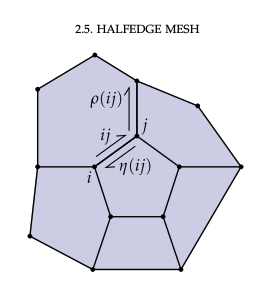 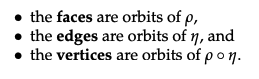

In [6]:
from gc_utils import *
alg = Algebra(3, 0, 1)
locals().update(alg.blades)

def half_edge(mesh):
    pts, faces = mesh
    HE = []
    
    # Process points: vector to pga point
    pts = [(e0+alg.vector((0, *p))-e2).dual() for p in pts]
    
    # Process faces: pga join
    faces = []
    for i, (v1, v2, v3) in enumerate(mesh[1]):
        face = {"vtx": [v1, v2, v3], "plane": pts[v1] & pts[v2] & pts[v3], "idx": i}
        HE.extend([
            {"from": v1, "to": v2, "line": pts[v1] & pts[v2], "face": face},
            {"from": v2, "to": v3, "line": pts[v2] & pts[v3], "face": face},
            {"from": v3, "to": v1, "line": pts[v3] & pts[v1], "face": face}
        ])
        
        face["edge"] = HE[i * 3 + 2] 
        for j in range(3):
            HE[i * 3 + ((j + 2) % 3)]["next"] = HE[i * 3 + ((j + 1) % 3)]["prev"] = HE[i * 3 + j]
        
        faces.append(face)
    
    # Process vertices
    pts = [{"idx": i, "vtx": p, "edge": next((e for e in HE if e["from"] == i), None)} for i, p in enumerate(pts)]
    
    # Assign twin edges
    for E in HE:
        E["twin"] = next((E2 for E2 in HE if E2["to"] == E["from"] and E2["from"] == E["to"]), None)
    
    return pts, HE, faces

pts, HE, faces = half_edge((vertices, f))

In [7]:
faces[0]['edge']['line']

0.0535 𝐞₀₁ + 0.0771 𝐞₀₂ + 0.0455 𝐞₀₃ + 0.0634 𝐞₁₂ + -0.0164 𝐞₁₃ + -0.0776 𝐞₂₃

In [8]:
# Line integral of a cummulative function f around a face p
# start from a starting edge through the half edges back to the starting edge
# Or if p is a vertex, "Line integral" along the star of p

def edges(p, f, s=None):
    e = p["edge"]
    while True:
        s = f(e, s)
        e = e["next"] if p.get("plane") else e["twin"]["next"]
        if e == p["edge"]:
            return s

In [9]:
def append_from_to(e, s):
    s = s or []
    s.append((e["from"], e["to"]))
    return s

edges(faces[0], append_from_to), edges(pts[0], append_from_to)

([(266, 281), (281, 331), (331, 266)],
 [(0, 24), (0, 41), (0, 38), (0, 272), (0, 112), (0, 36), (0, 274)])

### Discretization
How to discretize?

'There is no one “right” way
to discretize a given geometric quantity, but rather many different ways, each suited to a particular

purpose.'

The exterior derivative has a simple discretization: 

by repeated stokes theorem: 

measure on faces -> edges (-> vertices)

So the problem becomes assigning weights to edges (to vertices)

A weight depends on its connections e.g.
1. the distance from surrounding vertices
2. relative angle/length from surrounding edges/faces

Since we assign connectivity by half edges, we'd prefer integral over edges. 

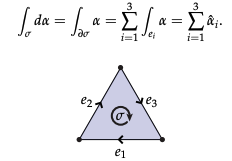

### Vector Area
The vector area is encode by a pga plane, or we can calculate it from the line integral:

In [10]:
face = faces[0]
face['plane'], norm(face['plane'])

(0.0016 𝐞₀ + -0.00448 𝐞₁ + -0.00835 𝐞₂ + -0.00332 𝐞₃, 0.01004041903100847)

In [11]:
def cross_ends(e, s):
    if s is None:
        s = np.zeros(3)
    i = e['from']
    j = e['to']
    s += np.cross(vertices[i], vertices[j])
    return s

va = edges(faces[0], cross_ends)
va, np.linalg.norm(va)

(array([-0.00448348, -0.00834668, -0.00332285]), 0.010040419031008493)

### Vertex Normal as Area/Volume Gradient
#### Cotangent formula for the Area Gradient
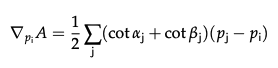
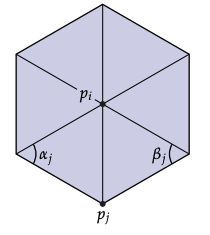

In [12]:
cotan = lambda h: (h['next']['line'] | h['prev']['line'])[0] / norm(h['face']['plane'])
cotan(HE[0])

0.6707622592444273

Numerically verify this formua? By updating faces around the point.

In [26]:
e = pts[0]['edge']
e['face']['plane']

0.00496 𝐞₀ + 0.00386 𝐞₁ + -0.0147 𝐞₂ + -0.00111 𝐞₃

In [14]:
def edge_area(e, s):
    s = s or 0
    s += norm(e['face']['plane'])
    return s

def edge_area_updated(e, s):
    s = s or 0
    v1, v2, v3 = e['face']['vtx']
    plane = pts[v1]['vtx'] & pts[v2]['vtx'] & pts[v3]['vtx']
    s += norm(plane)
    return s

edges(pts[0], edge_area), edges(pts[0], edge_area_updated)
    

(0.14376504116536087, 0.14376504116536087)

In [15]:
frame = [e.dual() for e in [e1, e2, e3]] # 3d for translating a point
frame

def point_area(x):
    temp_pt = pts[0]
    temp_pt['vtx'] = pts[0]['vtx'] + x
    return edges(temp_pt, edge_area_updated)

derivative(point_area, 0, alg, frame=frame, r_frame=frame)

-0.0219 𝐞₀₁₂ + 0.0903 𝐞₀₁₃ + 0.0208 𝐞₀₂₃

In [16]:
def area_gradient(e, s):
    if s is None:
        s = 0
    # times e0 to drop out the positional information
    s += (cotan(e) + cotan(e["twin"])) * e['line'] * e0 / 2
    return s

gradient = edges(pts[0], area_gradient)
gradient

-0.0219 𝐞₀₁₂ + 0.0903 𝐞₀₁₃ + 0.0208 𝐞₀₂₃

In [17]:
def area_gradient_position(e, s):
    if s is None:
        s = 0
    s += (cotan(e) + cotan(e["twin"])) * e['line'] / 2
    return s

edges(pts[0], area_gradient_position), pts[0]['vtx'] * gradient.dual()

(0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃ + -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃,
 0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃ + -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃ + 0.0336 𝐞₀₁₂₃)

PGA derivative? For translating a point, we use a "3d" frame

    [e.dual() for e in [e1, e2, e3]]

But for other geometic object? 

A bivector describes a rigid body motion, so for general approach we should use a bivector frame. In 3d-PGA, the bivector subspace is 6 dimensional. We can further split it into rotation and translation. Each of 3 dimension, which gives another reason of the "3d" frame we chose for translating a point.


In [18]:
frame = r_vector_frame(alg.frame, 2)
r_frame = [e.dual() for e in frame]

def point_area(b):
    temp_pt = pts[0]
    temp_pt['vtx'] = blade_exp(b/2).sw(pts[0]['vtx'])
    return edges(temp_pt, edge_area_updated)

derivative(point_area, 0, alg, frame=frame, r_frame=r_frame)

0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃ + -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃

In [19]:
# The rotational bivectors contribute to the position of the gradient. Why?
# It's a rotation of the whole space, with an axis through the orign
(
    frame, r_frame, 
    derivative(point_area, 0, alg, frame=frame[:3], r_frame=r_frame[:3]),
    derivative(point_area, 0, alg, frame=frame[3:], r_frame=r_frame[3:])
    )

([1 𝐞₀₁, 1 𝐞₀₂, 1 𝐞₀₃, 1 𝐞₁₂, 1 𝐞₁₃, 1 𝐞₂₃],
 [1 𝐞₂₃, -1 𝐞₁₃, 1 𝐞₁₂, 1 𝐞₀₃, -1 𝐞₀₂, 1 𝐞₀₁],
 -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃,
 0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃)

### Volume Gradient
In PGA, just sum of faces

In [33]:
def vol_gradient(e, s):
    if s is None:
        s = 0
    s += e['face']['plane']/6
    return s

vol_grad = edges(pts[0], vol_gradient)
vol_grad

0.00816 𝐞₀ + 0.00519 𝐞₁ + -0.0223 𝐞₂ + -0.00482 𝐞₃

In [ ]:
# The normal form area gradient and volune gradient are different
# But not far!
normalize(gradient.dual()), normalize(vol_grad)

(0.219 𝐞₁ + -0.948 𝐞₂ + -0.23 𝐞₃, 0.35 𝐞₀ + 0.222 𝐞₁ + -0.953 𝐞₂ + -0.206 𝐞₃)

### Discrete Hodge Star:
1. dual mesh
2. discrete primal and dual forms live in different places (no summation)

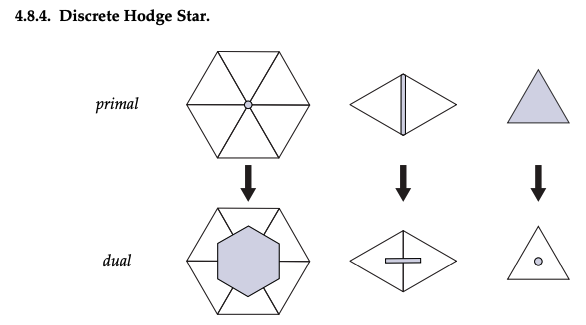


### Some ideas
The discretization of differential forms is a choice of how to integrate differential forms. Differentail form is a limited part of GC. We've seen some computations in GA doing the same thing as differential form. But GA provides richer structure and insights of the geometry. We need inspect the integration theory of GA to...